# Analysis of fMRI Stability Scans

The fMRI Stability scans are based on the fBIRN protocols, which are an adaptation of the published methods of [Friedman and Glover 2006](http://www.ncbi.nlm.nih.gov/pubmed/16649196).
The routine analysis uses the BIRN code and the scans are of a spherical phantom based on that used by BIRN.
The BIRN software and protocols are available at:

- [BIRN](http://www.birncommunity.org/tools-catalog/function-birn-stability-phantom-qa-procedures/)
- [New BHX Xcede Tools](http://www.nitrc.org/projects/bxh_xcede_tools)
- [BHX Tools Docs](https://xwiki.nbirn.org:8443/bin/view/Function-BIRN/AutomatedQA)

This notebook uses locally implemented equivalents of the BIRN analysis routines and presents more detailed results for the current scans. The results may be compared with those obtained by the standard BIRN analysis.

## Obtaining QA Scans

The long term stability series is `ep2d_fbirn_20min`. This is a long EPI time series (600 frames at 2s per frame). Each frame is a Siemens mosaic image which we'll unpack to a volume.

In [1]:
from __future__ import division, print_function

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np

from IPython.display import HTML
from datetime import datetime

# The analysis library
import fmriqa

In [2]:
# CRIC Skyra QA 29/1/2016
specified_date = '20160129'
series_description = 'ep2d_fbirn_20min'
scanner_code = ''

In [3]:
# Interface to query DICOM server for images
import dicom as dcm
from dcmfetch.queryinterface import QueryInterface, QIError
from dcmfetch.aettable import AetTable

import os
import platform

# Details of CRIC's DICOM Server
DFLT_LOCAL_AET = platform.node().split('.')[0] + 'Store'
aetable = AetTable('./dcmnodes.cf') if os.path.exists('./dcmnodes.cf') else AetTable('/etc/dcmnodes.cf')
qi = QueryInterface(aetable, DFLT_LOCAL_AET)
server = 'Dcm4Chee'

In [4]:
# Get the 20 minute protocol from the FMRIQA study
from operator import attrgetter
matching_patients = sorted(qi.pat_level_find(server, '*', 'PQA' + scanner_code + '*', '*', '*'), key=attrgetter('patid'))
seriess = []
for patid in [pat.patid for pat in matching_patients]:
    seriess += qi.combo_find(server, patid)
    
# Most recent scans
seriess.sort(key=lambda s: s.studydate)
if specified_date:
    try:
        index = [s.studydate.strip() for s in seriess].index(specified_date.strip())
        studydate = seriess[index].studydate
    except ValueError as e:
        raise ValueError('Date %s not found (%s) - nb: format should be YYYYmmdd' % (specified_date, e))
else:
    studydate = seriess[-1].studydate
series = filter(lambda s: s.studydate == studydate and s.description == series_description, seriess)[0]

In [5]:
# Fetch series from server to a temporary directory and read from there
from tempfile import mkdtemp
from shutil import rmtree
tempdir = mkdtemp()

# NB Returns a generator hence list() to force iteration
list(qi.series_level_fetch(server,
                      patid=series.patid, studyuid=series.studyuid, seriesuid=series.seriesuid,
                      savedir=tempdir))

time_series, (dx, dy, dz, dt) = fmriqa.read_mosaic_time_series(tempdir, ['*'])
dicom_series = fmriqa.read_dicom_objs_time_sorted(tempdir, ['*'])

rmtree(tempdir)
nt, nz, ny, nx = time_series.shape

assert nx>0 and ny>0 and nz>0 and nt>0
assert dx>0 and dy>0 and dz>0 and dt>0

tstart = 2 + nt%2
zmiddle = nz//2
central_slice_time_series = time_series[tstart:, zmiddle, :, :]
HTML('<h1>fBIRN QA Results on <em>%s</em></h1><h2>Scanner %s, Operator %s</h2>'
     % (
        datetime.strptime(studydate, '%Y%m%d').strftime('%d-%B-%Y'),
        dicom_series[0].StationName,
        dicom_series[0].OperatorsName      
     )
)

## Statistical Images

### Signal Image ###
This is a simple pixel by pixel average over time: $S_{ij} = \mu_{ij}$

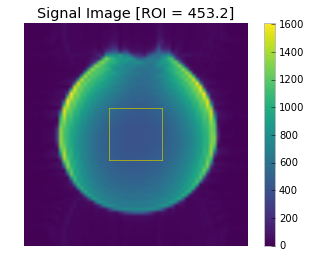

In [6]:
roisize = 15

# Average Image
plt.imshow(fmriqa.signal_image(central_slice_time_series), cmap='viridis')
plt.axis('off')
plt.title('Signal Image [ROI = %0.1f]' % fmriqa.signal_summary(central_slice_time_series, roisize=roisize))
plt.colorbar()

# Show the region of interest to be used
x1, x2, y1, y2 = int(nx/2-roisize/2), int(nx/2+roisize/2), int(ny/2-roisize/2), int(ny/2+roisize/2)
plt.axhline(y=y1, xmin=(x1+0.5)/nx,    xmax=(x2+0.5)/nx,    color='y')
plt.axvline(x=x1, ymin=(ny-y1-0.5)/ny, ymax=(ny-y2-0.5)/ny, color='y')
plt.axhline(y=y2, xmin=(x1+0.5)/nx,    xmax=(x2+0.5)/nx,    color='y')
plt.axvline(x=x2, ymin=(ny-y1-0.5)/ny, ymax=(ny-y2-0.5)/ny, color='y');

### Temporal Fluctuation Noise Image ###
The standard deviation of the temporal variation of each pixel (after quadratic detrending): $TFN_{ij} = \sigma_{ij}$

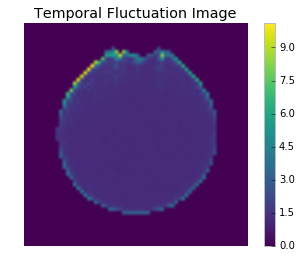

In [7]:
# Image of temporal fluctuations
plt.imshow(fmriqa.temporalnoise_fluct_image(central_slice_time_series), cmap='viridis')
plt.axis('off')
plt.title('Temporal Fluctuation Image')
plt.colorbar();

### Signal to Fluctuation Noise Ratio (SFNR) Image ###
Obtained by dividing the mean signal image by the Temporal Fluctuation Noise Image: $SFNR_{ij} = \frac{S_{ij}}{TFN_{ij}}$

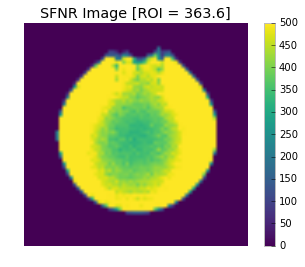

In [8]:
# Image of normalised temporal fluctuations
sfnri = fmriqa.sfnr_image(central_slice_time_series)
sfnri[sfnri>500] = 500
plt.imshow(sfnri, cmap='viridis')
plt.axis('off')
plt.title('SFNR Image [ROI = %0.1f]' % fmriqa.sfnr_summary(central_slice_time_series, roisize=roisize))
plt.colorbar();

### Static Spatial Noise Image ###
The average difference on a pixel by pixel basis of adjacent frames:

$$
SSN_{ij} = \Sigma_{n}{\left(I_{ij,2n+1} -  I_{ij,2n}\right)}
$$

That is the noise is estimated from the highest frequency temporal fluctuations which are assumed to be due just to
random noise.

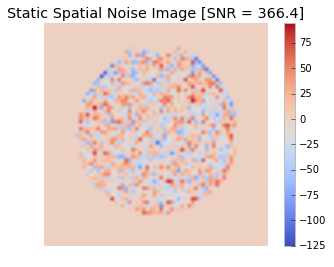

In [9]:
# Image of average spatial noise
plt.imshow(fmriqa.static_spatial_noise_image(central_slice_time_series), cmap='coolwarm')
plt.axis('off')
plt.title('Static Spatial Noise Image [SNR = %0.1f]' % fmriqa.snr_summary(central_slice_time_series, roisize=roisize))
plt.colorbar();

## ROI Time Course Analysis


### Fluctuation and Drift ###
We plot the time course of the signal intensity in a central ROI. In addition, we calculate a detrending quadratic.
Using this we calculate a low frequncy *drift* (modelled by the quadratic) and a residual *fluctuation*.

Drift (%) is calculated as the range of values in the fit divided by the mean signal *before* detrending:

$$Drift = \frac{max_{fit} - min_{fit}}{\overline{signal}} \times 100 \% $$

Fluctuation (%) is calculated as:

$$PF = \frac{\sigma}{\overline{signal}} \times 100 \% $$


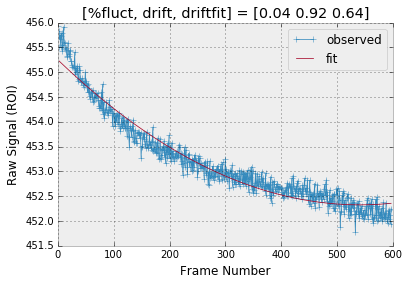

In [10]:
# Time course of gain fluctuations in an ROI
time_course = fmriqa.roi_means_time_course(central_slice_time_series, roisize=roisize)
nt = len(time_course)
(a, b, c) = np.polyfit(xrange(nt), time_course, deg=2)
trend = np.polyval((a, b, c), xrange(nt))
plt.plot(np.arange(nt), time_course, '+-', label='observed')
plt.plot(np.arange(nt), trend, '-', label='fit')
sd, fluct, drift_raw, drift_fit = fmriqa.fluctuation_and_drift(
                              central_slice_time_series, roisize=roisize)
summary_vals = (fluct, drift_raw, drift_fit)
plt.title('[%%fluct, drift, driftfit] = [%.2f %.2f %.2f]' % summary_vals)
plt.xlabel('Frame Number')
plt.ylabel('Raw Signal (ROI)')
plt.grid('on')
plt.legend();

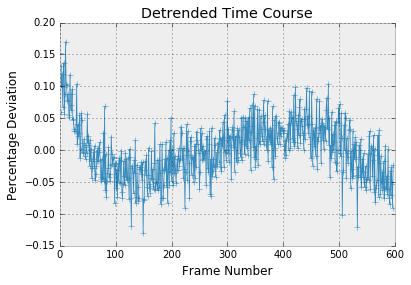

In [11]:
# Time course of gain fluctuations in an ROI (quadratically detrended)
detr_time_course = fmriqa.detrended_roi_time_course(
                     central_slice_time_series, roisize=roisize)
plt.plot(np.arange(nt), 100*detr_time_course/trend, '+-')
plt.title('Detrended Time Course')
plt.xlabel('Frame Number')
plt.ylabel('Percentage Deviation')
plt.grid('on');

### Fourier Analysis ###
A mixed radix FFT is applied to the residuals after detrending and a *magnitude* spectrum (and a power spectrum) is plotted. This is intended to show individual sources of temporal fluctuation
such as the cold head pump, gradient mechanical resonances or 50Hz aliasing.

The spectrum is scaled to the average signal intensity.


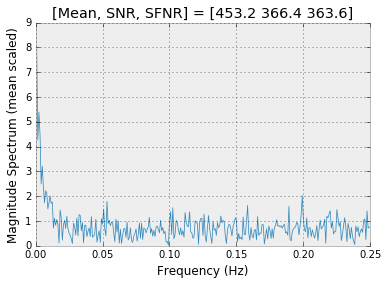

In [12]:
# Magnitude spectrum of temporal fluctuations in an ROI
spectrum = fmriqa.magnitude_spectrum(central_slice_time_series, roisize=roisize)
nf = len(spectrum)
frequencies = np.linspace(0, (nf-1.0)/dt/nf/2.0, num=nf)
df = 1/dt
plt.plot(frequencies, spectrum, '-')
summary_vals = (fmriqa.signal_summary(central_slice_time_series, roisize=roisize),
                fmriqa.snr_summary(central_slice_time_series, roisize=roisize),
                fmriqa.sfnr_summary(central_slice_time_series, roisize=roisize))

plt.title('[Mean, SNR, SFNR] = [%.1f %.1f %.1f]' % summary_vals)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude Spectrum (mean scaled)')
plt.grid('on');

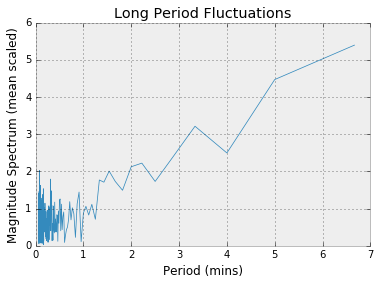

In [13]:
# Zoom in on the region with periods between 10s and 10mins and display as period rather than frequency

# NB First three components will be DC and 20mins and 10mins
maxf = int(round(nf * 0.5 / df))
spectrum_low = spectrum[3:maxf]
freq_low = frequencies[3:maxf]

periods_low = np.array(list(reversed(1/freq_low)))
spectrum_low = np.array(list(reversed(spectrum_low)))

plt.plot(periods_low/60.0, spectrum_low)
plt.title('Long Period Fluctuations')
plt.xlabel('Period (mins)')
plt.ylabel('Magnitude Spectrum (mean scaled)')
plt.grid('on');

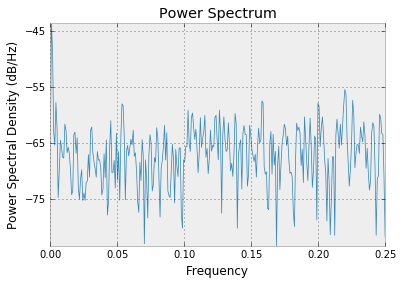

In [14]:
# Power spectrum of temporal fluctuations in an ROI
time_course = fmriqa.roi_means_time_course(central_slice_time_series,
                                    roisize=roisize)
plt.psd(time_course/np.mean(time_course), len(time_course),
          1/dt, detrend=fmriqa.detrend_quadratic)
plt.plot()
plt.title('Power Spectrum');

### Weisskoff Analysis ###
This takes the time series of the average signal intensity within ROIs for a range of different ROI sizes and plots (on a log-log scale) the Coefficient of Variation (normalised SD) *wrt* to time against the
size of the ROI in pixels. The expected relation in the absence of additional correlations is $1/n$ so in the absence of system instabilities the points should follow a straight line of slope -1 on the log-log plot. However, system instabilities tend to lead to a plateau above a certain size ROI.

In the original Weisskoff article the relative fluctuation is given by:

$$
F_n = \frac{\sqrt{\frac{1}{N-1}\sum\limits_{i=1..N} \left(m_{n,i} - \overline{m_n}\right)^2}}{\overline{m_n}}
$$

which is compared to:

$$
F_{n, t} = \frac{1}{n \cdot SNR_o}  
$$

$SNR_o$ being derived using the ROI vs background method:

$$
SNR_o = \frac{\sum\limits_i m_i}{1.53 \sum\limits_i \sigma_i}
$$
Friedman and Glover uses the variance for a ROI of size one as the comparison instead so the curves always start together.

They also define a a single number - the *Radius of Decorrelation* to characterise the curve:

$$R_{DC} = \frac{CV_{1}}{CV_{N_{max}}}$$

Although unclear from Friedman and Glover it seems the time series are detrended before calculating the Coefficient of Variation.


Most of the results to date at CRIC show rather erratic behaviour and do not follow the expected curve. Although this could be a phantom issue, as the
results are calculated on the basis of *mean* intensities and not *standard deviations* within ROIs phantom inhomogeneity ought not to contribute directly.



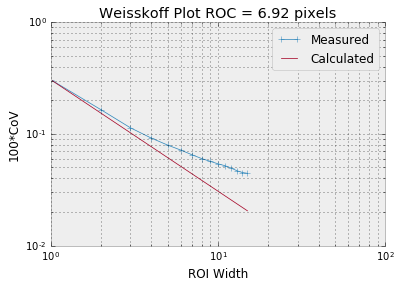

In [15]:
# Weisskoff plot of fluctuation noise as a function of ROI size
roc, covs = fmriqa.weisskoff(central_slice_time_series, max_roisize=roisize)

plt.loglog(range(1, len(covs)+1), 100*covs, '+-', label='Measured')
plt.loglog(range(1, len(covs)+1),
             100*covs[0] / np.arange(1, len(covs)+1),
             '-', label = 'Calculated')
plt.title('Weisskoff Plot ROC = %.2f pixels' % roc)
plt.xlabel('ROI Width')
plt.ylabel('100*CoV')
plt.grid('on', 'both')
plt.legend();

### Positional Stability (Centre of Mass) ###
This is done by determining the position of the spherical phantom in three coordinates at each time point and plotting the positions as a function of time.

The variability here is usually very small, presumably the significant misregistration expected in the epi *phase encode* direction from $B_0$ drift is compensated in the Siemens sequence.

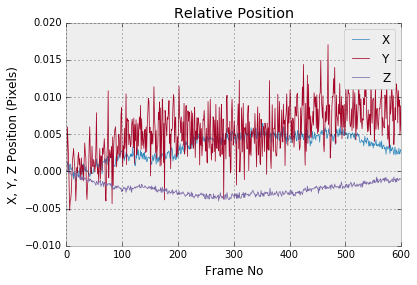

In [16]:
# Movement of the phantom Centre of Gravity from its starting position
cofg = fmriqa.centre_of_mass(time_series)
plt.plot(range(1, len(cofg)+1),
           [x-cofg[0][0] for (x,y,z) in cofg], '-', label='X')
plt.plot(range(1, len(cofg)+1),
           [y-cofg[0][1] for (x,y,z) in cofg], '-', label='Y')
plt.plot(range(1, len(cofg)+1),
           [z-cofg[0][2] for (x,y,z) in cofg], '-', label='Z')
plt.title('Relative Position')
plt.xlabel('Frame No')
plt.ylabel('X, Y, Z Position (Pixels)')
plt.grid('on')
plt.legend();

### Ghostiness ###
This is an assessment of the severity of ghosting in the images. It is generated by comparing the signal intensity in background regions liable to ghosting with
the signal in the phantom. This is done by manipulating image masks.

The mean intensity of the voxels in the *ghost* mask and the mean intensity of the worst (*brightest*) ten percent of these are plotted as a function of time.

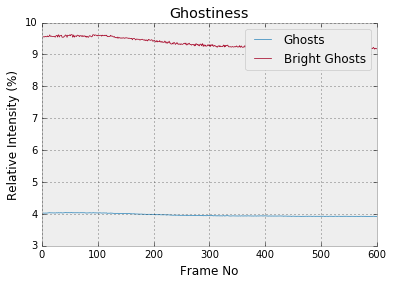

In [17]:
# Average strength of ghosts and of the 'brightest' ghosts
pmeans, gmeans, bright_gmeans, snrs = fmriqa.ghostiness_trends(time_series)
plt.plot(range(1, len(gmeans)+1), 100*gmeans/pmeans, '-', label='Ghosts')
plt.plot(range(1, len(bright_gmeans)+1), 100*bright_gmeans/pmeans, '-', label='Bright Ghosts')

plt.title('Ghostiness')
plt.xlabel('Frame No')
plt.ylabel('Relative Intensity (%)')
plt.grid('on')
plt.legend();

### Image Smoothness (FWHM) ###
This is a reimplementation of the [Afni](http://afni.nimh.nih.gov/afni/ Afni) tool `3dFWHM` which determines how the image smoothness varies along the time series.

The analysis along the Z direction frequently breaks down and these points have been eliminated from the plot. The `3dFWHM` encounters similar difficulties and these points are also eliminated from the
fBIRN analysis that uses `3dFWHM`.

The method is based on Gaussian Random Field Theory. There are details of the theory here:

1. Jenkinson FMRIB Tech Rep TR00MJ3
2. Fornan et al, MRM 33:636-647, 1995

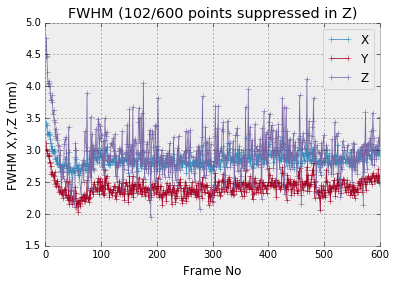

In [18]:
# Image Smoothness (Gaussian Random Field Theory)
fwhmx, fwhmy, fwhmz = fmriqa.fwhm_smoothness_xyz_preprocessed(time_series, (dx,dy,dz))

p1, = plt.plot(range(1, len(fwhmx)+1), fwhmx, '+-', label='X')
p2, = plt.plot(range(1, len(fwhmy)+1), fwhmy, '+-', label='Y')

# Filter out the negative values for Z
# We tagged them as they were giving NaNs from log(-ve no.)
# The result now seems to be the same as the fBIRN analysis
framenos = range(1, len(fwhmz)+1)
framenos, fwhmz = zip(*[(frameno, f) for (frameno, f) in zip(framenos, fwhmz) if f>0])
p3, = plt.plot(framenos, fwhmz, '+-', label='Z')

plt.title('FWHM (%d/%d points suppressed in Z)' % (len(time_series)-len(framenos), len(time_series)))
plt.xlabel('Frame No')
plt.ylabel('FWHM X,Y,Z (mm)')
plt.grid('on')
plt.legend([p1,p2,p3], ['X', 'Y', 'Z']);

### Transmitter & Receiver Gains and Centre Frequency ###
We don't currently measure these though they are available from the DICOM header. The standard tag `ImagingFrequency` quotes the frequency to &plusmn;1Hz.
Unfortunately, it doesn't seem to track the frequency during the scan - there's just the same nominal value in all the frames so it's no use for looking at drift
during the scan related to the gradient heating effects on the shim.

Transmitter calibration is in the Series Shadow Data No. 2: `TransmitterCalibration`. Again this is a single value for the whole series.


In [19]:
freqs = [float(d.ImagingFrequency) for d in dicom_series]
print('Frequency =', list(set(freqs))[0], 'MHz')
from dcmextras.siemenscsa import csa
print('Transmitter Ref. =', float(csa(dicom_series[0])['TransmitterCalibration']), 'V')

Frequency = 123.256786 MHz
Transmitter Ref. = 332.149469 V
